<a href="https://colab.research.google.com/github/ProvenDruid/FFN-projects/blob/main/ffn_heartDisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# NEW!
import sklearn.metrics as skm

# for dataset management
import pandas as pd

import matplotlib.pyplot as plt
from IPython import display
from matplotlib_inline.backend_inline import set_matplotlib_formats

In [ ]:
# import the data
url  = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
data = pd.read_csv(url,sep=',',header=None)
data.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','DISEASE']


# data contain some ?'s; replace with NaN and drop those rows
data = data.replace('?',np.nan).dropna()

data.shape

(297, 14)

In [ ]:
# z-score the non-categorical columns
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop(['sex','fbs','exang','DISEASE'])
cols2zscore

for c in cols2zscore:
  d = pd.to_numeric(data[c]) # force to numeric (addresses some data-format issues)
  data[c] = (d - d.mean())/d.std(ddof=1)

data['DISEASE'][data['DISEASE']>0]=1

<ipython-input-3-dc7eb3ffd003>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DISEASE'][data['DISEASE']>0]=1


In [ ]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[data.keys().drop('DISEASE')].values ).float()
labelsT = torch.tensor( data['DISEASE'].values ).float()
labelsT = labelsT[:,None] # transform to matrix

In [ ]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 20
train_loader = DataLoader(train_dataDataset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

In [ ]:
# create a class for the model
def createTheDrNet():

  class DrNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(13,32)

      ### hidden layer
      self.fc1 = nn.Linear(32,64)
      self.fc2 = nn.Linear(64,10)

      ### output layer
      self.output = nn.Linear(10,1)

    # forward pass
    def forward(self,x):
      x = F.relu(self.input(x))
      x = F.relu(self.fc1(x) )
      x = F.relu(self.fc2(x))
      return self.output(x)

  # create the model instance
  DrNet = DrNet()

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(DrNet.parameters(),lr=.0001)

  return DrNet,lossfun,optimizer

In [ ]:
# test the model on a bit of data
DrNet,lossfun,optimizer=createTheDrNet()

X,y = next(iter(train_loader))
yHat = DrNet(X)

# test the loss function
lossfun = nn.BCEWithLogitsLoss()
#lossfun(yHat,y)

In [ ]:
# a function that trains the model

# global parameter
numepochs = 100

def trainTheModel():

  # create a new model
  DrNet,lossfun,optimizer = createTheDrNet()

  # initialize losses
  trainAcc=[]
  testAcc=[]
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    DrNet.train()

    # loop over training data batches
    batchAcc=[]
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = DrNet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      #compute accuracy
      accOfBatch=(((yHat>0).float())==y).float()
      accOfBatchPercentage=100*torch.mean(accOfBatch)
      batchAcc.append(accOfBatchPercentage)

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    #accuracy of each epoch
    trainAcc.append( np.mean(batchAcc) )

    # test accuracy
    DrNet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = DrNet(X)

    accOfTest=(((yHat>0).float())==y).float()
    accOfTestPercentage=100*torch.mean(accOfTest)
    testAcc.append(accOfTestPercentage)
    testLoss[epochi] = lossfun(yHat,y).item()

  # function output
  return trainLoss,testLoss,trainAcc,testAcc,DrNet

In [ ]:
trainLoss, testLoss, trainAcc, testAcc, DrNet = trainTheModel()

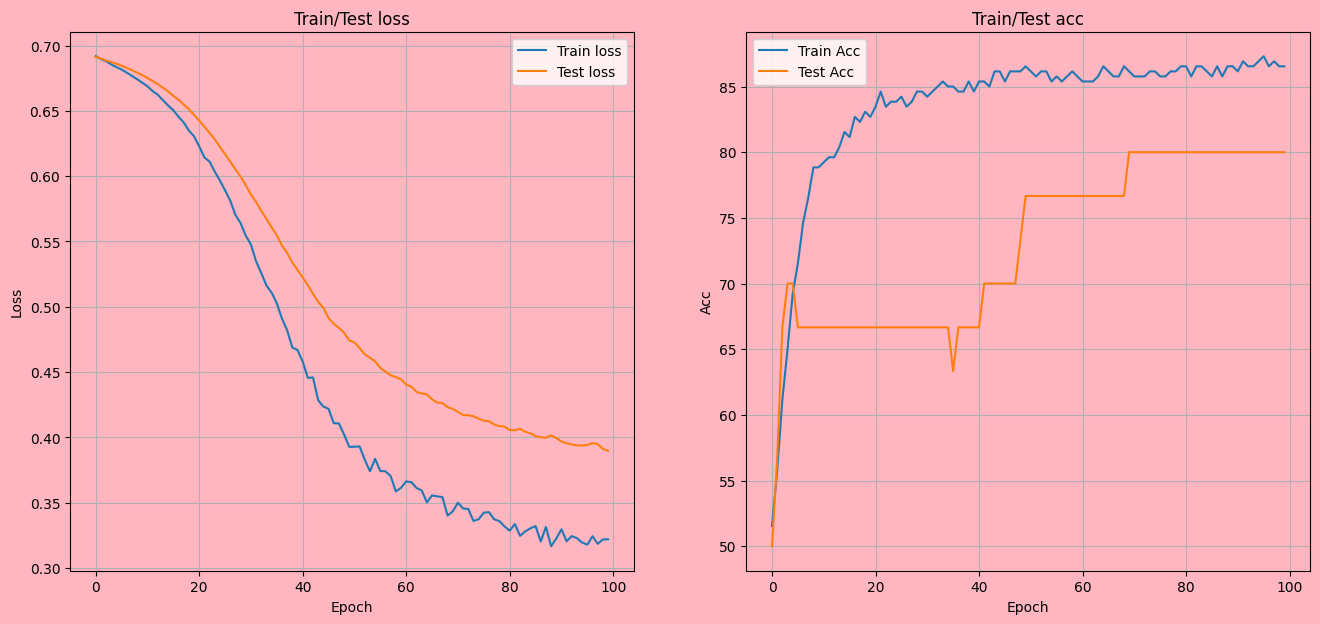

In [ ]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(16,7))
fig.set_facecolor('lightpink')

ax[0].set_facecolor('lightpink')
ax[0].plot(trainLoss,label='Train loss')
ax[0].plot(testLoss,label='Test loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()

#accuracy
ax[1].set_facecolor('lightpink')
ax[1].plot(trainAcc,label='Train Acc')
ax[1].plot(testAcc,label='Test Acc')
ax[1].set_title('Train/Test acc')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Acc')
ax[1].legend()
ax[1].grid()

plt.show()

In [ ]:
# show predictions and real values
yHatTrain = DrNet(train_data)
trPreds=(yHatTrain>0).float()
matches=(trPreds==train_labels).float()
accPerc=100*torch.mean(matches)
print(f"this is the accPerc of train {accPerc:.2f}")
yHatTest  = DrNet(test_data)
testPreds=(yHatTest>0).float()
matchesTest=(testPreds==test_labels).float()
accPercTest=100*torch.mean(matchesTest)
print(f"this is the accPerc of test {accPercTest:.2f}")

this is the accPerc of train 86.89
this is the accPerc of test 80.00
